In [1]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [2]:

d_model = 256
n_tokens = 10
sequence_length = 6
n_heads = 1
dataset = rollout.dataset.InductionDataset(n_tokens, sequence_length)
simpleModel = rollout.models.FlexibleTransformer(d_model, n_tokens, sequence_length, n_heads, n_attn_layers=1)
optimizer = optim.AdamW(simpleModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

simple_train_losses, simple_test_losses = rollout.models.optimize_model(simpleModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.4862475395202637, Test Loss: 2.3510284423828125
Epoch 100: Train Loss: 1.3486535549163818, Test Loss: 1.3365025520324707
Epoch 200: Train Loss: 1.289481520652771, Test Loss: 1.289735198020935
Epoch 300: Train Loss: 1.302837610244751, Test Loss: 1.2885851860046387
Epoch 400: Train Loss: 1.297789454460144, Test Loss: 1.2576392889022827


In [3]:
d_model = 128
n_heads = 1

complexModel = rollout.models.FlexibleTransformer(d_model, n_tokens, sequence_length, n_heads, n_attn_layers=2)
optimizer = optim.AdamW(complexModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

complex_train_losses, complex_test_losses =  rollout.models.optimize_model(complexModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.4811489582061768, Test Loss: 2.38681697845459
Epoch 100: Train Loss: 0.00025108284899033606, Test Loss: 0.00024229240079876035
Epoch 200: Train Loss: 0.00011742297647288069, Test Loss: 0.0001329372898908332
Epoch 300: Train Loss: 8.656803402118385e-05, Test Loss: 9.244960529031232e-05
Epoch 400: Train Loss: 6.657277117483318e-05, Test Loss: 6.551215483341366e-05


In [4]:
num_simple_params = sum(p.numel() for p in simpleModel.parameters() if p.requires_grad)
num_complex_params = sum(p.numel() for p in complexModel.parameters() if p.requires_grad)
print(f"Simple model has {num_simple_params} parameters")
print(f"Complex model has {num_complex_params} parameters")

Simple model has 268298 parameters
Complex model has 134666 parameters


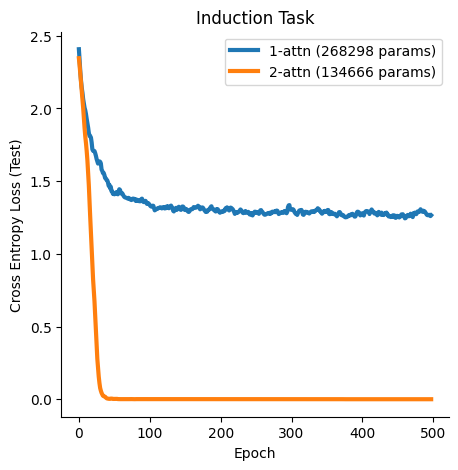

In [5]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(rollout.utils.movmean(np.array(simple_train_losses), 3), label=f"1-attn ({num_simple_params} params)", lw=3)
ax.plot(rollout.utils.movmean(np.array(complex_test_losses), 3), label=f"2-attn ({num_complex_params} params)", lw=3)
ax.set_ylabel("Cross Entropy Loss (Test)")  
ax.legend()
ax.set_title("Induction Task")
ax.set_xlabel("Epoch")
sns.despine()

In [28]:
X, y = dataset.generate_batch(100, type="test")

simple_x, simple_weights = simpleModel.forward_with_weights(X)
complex_x, complex_weights = complexModel.forward_with_weights(X)
y_pred_simple = torch.argmax(simple_x, dim=1)
y_pred_complex = torch.argmax(complex_x, dim=1)

# now print some performance stats
#corrcoef
cc_simple = np.corrcoef(y_pred_simple.detach().numpy(), y)[0, 1]
cc_complex = np.corrcoef(y_pred_complex.detach().numpy(), y)[0, 1]

# calculate percent correct classification
pcc_simple = np.mean(y_pred_simple.detach().numpy() == y.numpy())
pcc_complex = np.mean(y_pred_complex.detach().numpy() == y.numpy())

print(f"Simple Model \tCC: {cc_simple:.2f} \t PCC: {pcc_simple:.2f}")
print(f"Complex Model \tCC: {cc_complex:.2f} \t PCC: {pcc_complex:.2f}")


Simple Model 	CC: 0.25 	 PCC: 0.37
Complex Model 	CC: 1.00 	 PCC: 1.00


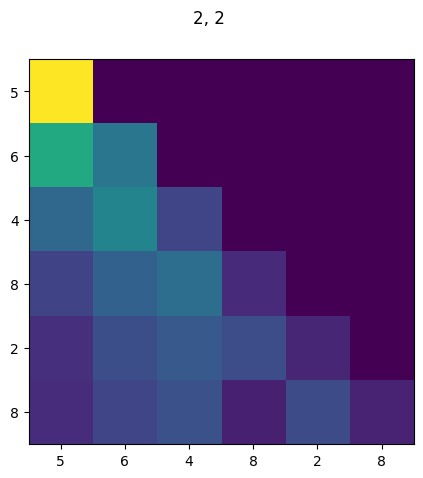

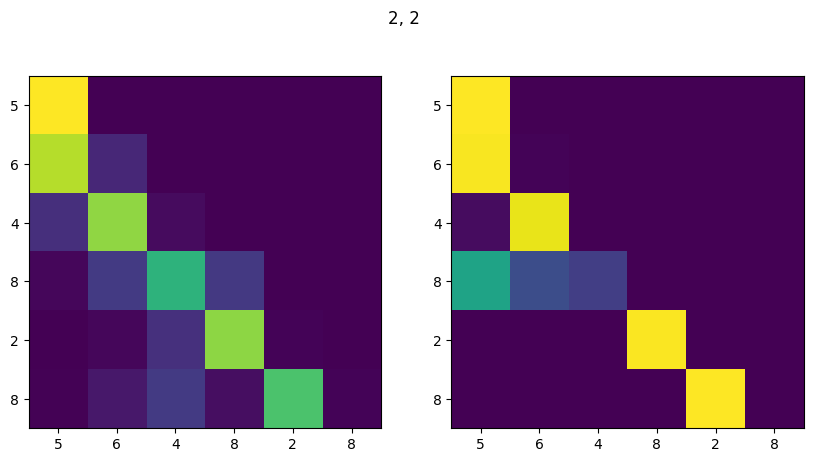

In [15]:
sample = np.random.randint(0, len(y))


fig, ax = plt.subplots(1, len(simple_weights), figsize=(10, 5))
for ix, aw in enumerate(simple_weights):
    plt.imshow(aw[sample])
    plt.xticks(np.arange(sequence_length), labels=X[sample].numpy())
    plt.yticks(np.arange(sequence_length), labels=X[sample].numpy())
fig.suptitle(f"{y[sample]}, {y_pred_simple[sample]}")

fig, ax = plt.subplots(1, len(complex_weights), figsize=(10, 5))
for ix, aw in enumerate(complex_weights):
    ax[ix].imshow(aw[sample])
    ax[ix].set_xticks(np.arange(sequence_length), labels=X[sample].numpy())
    ax[ix].set_yticks(np.arange(sequence_length), labels=X[sample].numpy())

fig.suptitle(f"{y[sample]}, {y_pred_complex[sample]}")
plt.show()